# <span style="font-family: Arial, sans-serif; color:#97f788">xbooster</span>
## <span style="font-family: Arial, sans-serif; color:navyblue">CatBoost - Getting started</span>

<span style="font-family: Arial, sans-serif; color:navyblue">Repo: <a href="https://github.com/xRiskLab/xBooster" title="GitHub link">https://github.com/xRiskLab/xBooster</a></span>

In [1]:
import sys
from pathlib import Path

# Get the absolute path to the project root directory
ROOT_DIR = str(Path().absolute().parent)
sys.path.append(ROOT_DIR)

In [2]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool

from xbooster.cb_constructor import CatBoostScorecardConstructor

# 1. Load and prepare the data
data_path = Path("__file__").parent / "data" / "test_data_01d9ab8b.csv"
credit_data = pd.read_csv(str(data_path))
num_features = ["Gross_Annual_Income", "Application_Score", "Bureau_Score"]
categorical_features = ["Time_with_Bank"]
features = num_features + categorical_features

# Prepare X and y
X = credit_data[features]
y = credit_data["Final_Decision"].replace({"Accept": 1, "Decline": 0})

# 2. Create CatBoost Pool
pool = Pool(
    data=X,
    label=y,
    cat_features=categorical_features,
)

# 3. Initialize and train CatBoost model
model = CatBoostClassifier(
    iterations=100,
    allow_writing_files=False,
    depth=1,
    learning_rate=0.1,
    verbose=0,
    one_hot_max_size=9999,  # Key for interpretability
)
model.fit(pool)

# 4. Create and fit the scorecard constructor
constructor = CatBoostScorecardConstructor(model, pool)

# 5. Construct the scorecard
scorecard = constructor.construct_scorecard()
print("\nScorecard:")
display(scorecard.head(3))

# Print raw leaf values
print("\nRaw Leaf Values:")
display(scorecard[["Tree", "LeafIndex", "LeafValue", "WOE"]].head(10))

# 6. Make predictions using different methods
raw_scores = constructor.predict_score(X, method="raw")
woe_scores = constructor.predict_score(X, method="woe")
points_scores = constructor.predict_score(X, method="pdo")


Scorecard:


/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_37789/3699708198.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = credit_data["Final_Decision"].replace({"Accept": 1, "Decline": 0})
/Users/deburky/Documents/python/xBooster/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Tree,LeafIndex,Feature,Sign,Split,Count,NonEvents,Events,EventRate,WOE,IV,CountPct,DetailedSplit,LeafValue,Conditions
0,0,0,Application_Score,<=,782.5,110,77,33,0.300000,-3.047207,1.829060,0.088496,Application_Score <= 782.5,-0.072,Application_Score <= 782.5
1,0,1,Application_Score,>,782.5,1133,47,1086,0.958517,0.940200,0.054791,0.911504,Application_Score > 782.5,0.181,Application_Score > 782.5
2,1,0,Application_Score,<=,822.5,149,88,61,0.409396,-2.566372,1.259692,0.119871,Application_Score <= 822.5,-0.033,Application_Score <= 822.5



Raw Leaf Values:


,Tree,LeafIndex,LeafValue,WOE
0,0,0,-0.072,-3.047207
1,0,1,0.181,0.940200
2,1,0,-0.033,-2.566372
3,1,1,0.168,1.180708
4,2,0,-0.038,-2.616803
5,2,1,0.156,1.183539
6,3,0,0.004,-2.042905
7,3,1,0.149,1.531790
8,4,0,-0.037,-2.610824
9,4,1,0.138,1.298491


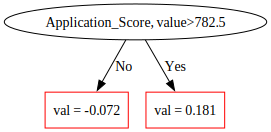

In [3]:
model.plot_tree(tree_idx=0, pool=pool)

### Compare performance of scores

In [4]:
from sklearn.metrics import roc_auc_score

# Original CatBoost predictions
cb_preds = model.predict(X, prediction_type="RawFormulaVal").round(3)
cb_gini = 2 * roc_auc_score(y, cb_preds) - 1
print("\nGini Coefficients:")
print(f"CatBoost: {cb_gini:.4f}")

# Raw scores
raw_gini = 2 * roc_auc_score(y, raw_scores) - 1
print(f"Raw Scores: {raw_gini:.4f}")

# WOE scores
woe_gini = 2 * roc_auc_score(y, woe_scores) - 1
print(f"WOE Scores: {woe_gini:.4f}")

# Points scores
points_gini = 2 * roc_auc_score(y, points_scores) - 1
print(f"Points Scores: {points_gini:.4f}")

# 9. Get feature importance
feature_importance = constructor.get_feature_importance()
print("\nFeature Importance:")
for feature, importance in feature_importance.items():
    print(f"{feature}: {importance:.4f}")

# assert of raw scores and cb_preds
np.testing.assert_allclose(raw_scores, cb_preds, rtol=1e-2, atol=1e-2)


Gini Coefficients:
CatBoost: 0.8797
Raw Scores: 0.8797
WOE Scores: 0.8797
Points Scores: 0.8797

Feature Importance:
Application_Score: 0.3455
Bureau_Score: 0.4797
Gross_Annual_Income: 0.1663
Time_with_Bank: 0.0085


### Plot feature importance

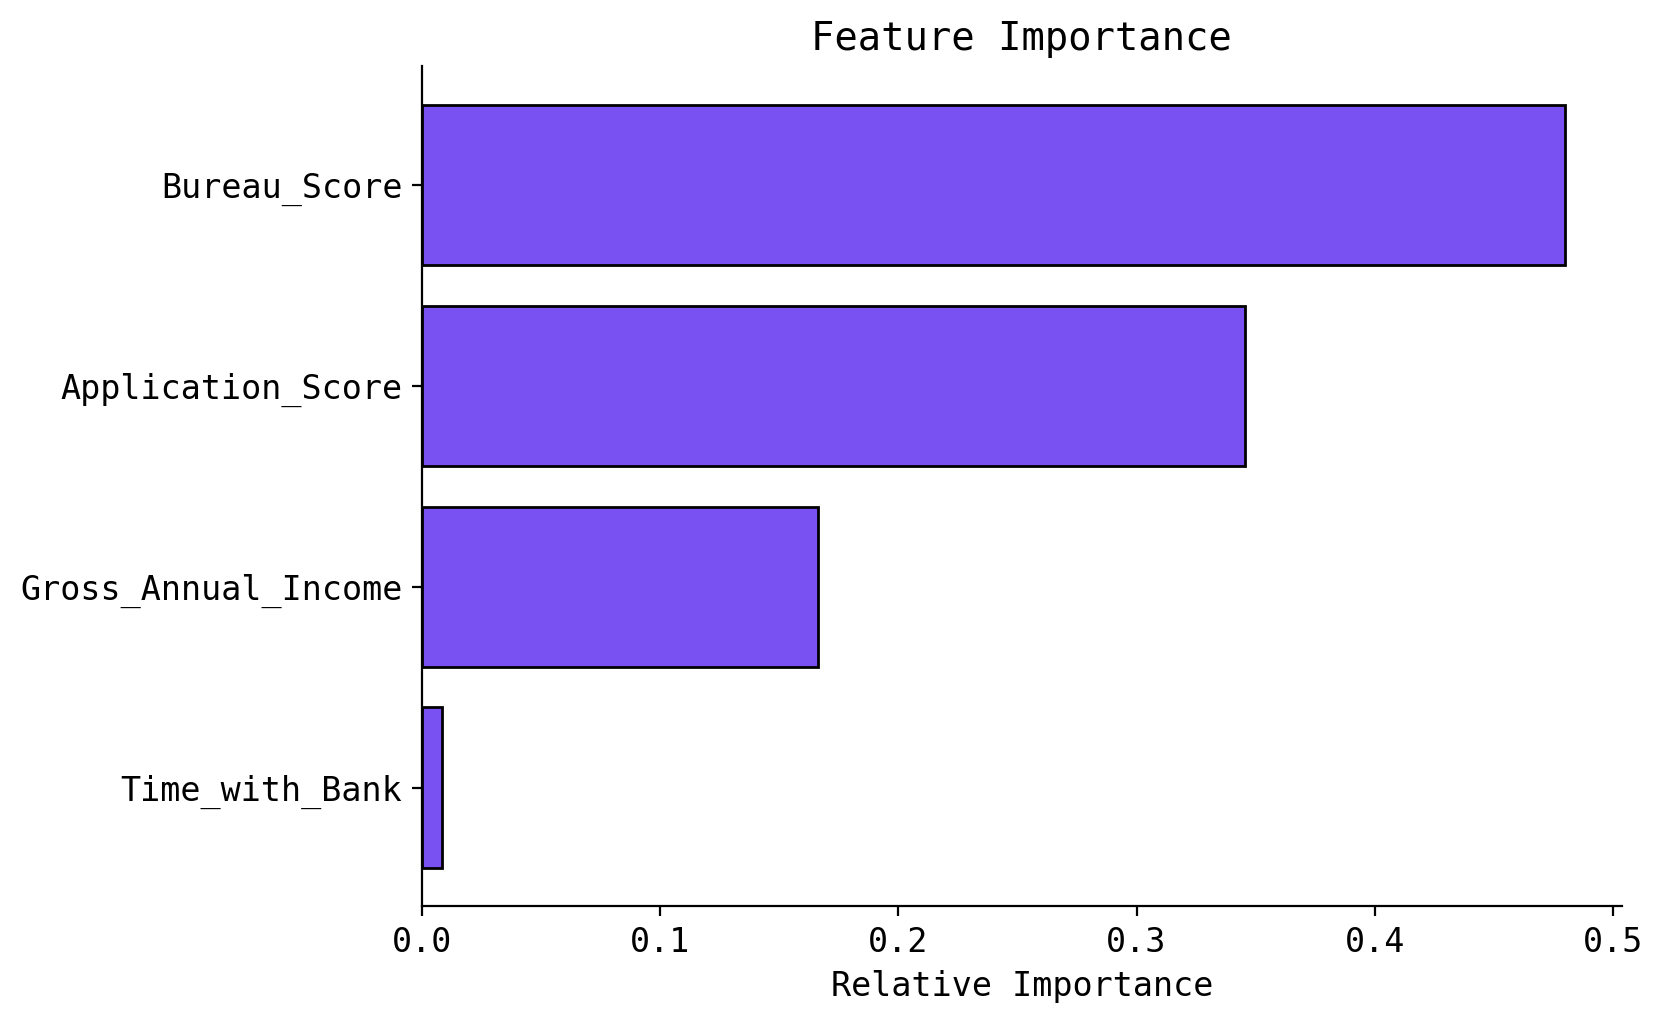

In [5]:
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Plot feature importance
constructor.plot_feature_importance()